### Train Module 1 on V7 database of segmented lungs   


In [1]:
# In[1]:

import os, sys, shutil
from os import listdir
from os.path import isfile, join 
import random
import numpy as np
import cv2
import pandas as pd


In [2]:
# In[2]:

from MODULES.Generators import train_generator_1, val_generator_1, test_generator_1
from MODULES.Generators import train_generator_2, val_generator_2, test_generator_2
from MODULES.Networks import ResNet_Atrous, Dense_ResNet_Atrous
from MODULES.Networks import ResUNet, ResUNet_Big, ResUNet_CR, ResUNet_CR_Big
from MODULES.Losses import dice_coeff
from MODULES.Losses import tani_loss, tani_coeff, weighted_tani_coeff
from MODULES.Losses import weighted_tani_loss, other_metrics
from MODULES.Constants import _Params, _Paths
from MODULES.Utils import get_class_threshold, get_model_memory_usage
import tensorflow as tf 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import model_from_json, load_model 
from tensorflow.python.client import device_lib
import matplotlib.pyplot as plt
import datetime

# automatic reload of external definitions if changed during testing
%load_ext autoreload
%autoreload 2


In [ ]:
# In[3]:

# ### DEVICES

physical_devices_GPU = tf.config.list_physical_devices('GPU') 
print("Num GPUs:", len(physical_devices_GPU))

physical_devices_CPU = tf.config.list_physical_devices('CPU') 
print("Num CPUs:", len(physical_devices_CPU)) 

local_device_protos = device_lib.list_local_devices()
print(local_device_protos)


In [4]:
# In[4]:

# ### MODEL SELECTION
HEIGHT, WIDTH, CHANNELS, IMG_COLOR_MODE, MSK_COLOR_MODE, NUM_CLASS, \
    KS1, KS2, KS3, DL1, DL2, DL3, NF, NFL, NR1, NR2, DIL_MODE, W_MODE, LS, \
    TRAIN_SIZE, VAL_SIZE, TEST_SIZE, DR1, DR2, CLASSES, IMG_CLASS = _Params()

TRAIN_IMG_PATH, TRAIN_MSK_PATH, TRAIN_MSK_CLASS, VAL_IMG_PATH, \
    VAL_MSK_PATH, VAL_MSK_CLASS, TEST_IMG_PATH, TEST_MSK_PATH, TEST_MSK_CLASS = _Paths()

model_selection = 'model_' + str(NF) + 'F_' + str(NR1) + 'R1_' + str(NR2) + 'R2'

model_number = str(datetime.datetime.now())[0:10] + '_' + \
               str(datetime.datetime.now())[11:13] + '_' + \
               str(datetime.datetime.now())[14:16]

NEW_RUN = True # or False if running from checkpoint or the end of a previous run.
NEW_MODEL_NUMBER = True


In [5]:
# In[5]:
    
if NEW_RUN:
    
    model_number = str(datetime.datetime.now())[0:10] + '_' + \
                   str(datetime.datetime.now())[11:13] + '_' + \
                   str(datetime.datetime.now())[14:16]

    model = ResNet_Atrous()
    print('ResNet_Atrous model selected')   

    model.compile(optimizer=Adam(), loss=weighted_tani_loss, metrics=[tani_coeff]) 
    
    print(model.name + ' model selected')
    
    initial_epoch = 0      
    
else:

    model_selection = 'model_' + str(NF) + 'F_' + str(NR1) + 'R1_' + str(NR2) + 'R2'
    model_number = '2020-07-21_14_55' # Enter here the model number from an earlier run
    
    load_saved = True
    load_best = False # or False

    if load_saved:
        # read in 
        json_file = open('models/' + model_selection + '_' + model_number + '.json', 'r')
        loaded_model_json = json_file.read()
        json_file.close()
        
        # model = model_from_json(loaded_model_json)       
        # model.compile(optimizer=Adam(), loss=weighted_tani_loss, metrics=[tani_coeff])
        
        # The following allows the loaded model to be optimized for multiple GPUs.
        strategy = tf.distribute.MirroredStrategy()
        with strategy.scope():
            model = model_from_json(loaded_model_json)
            model.compile(optimizer=Adam(), loss=weighted_tani_loss, metrics=[tani_coeff])
                        
        # load weights into new model
        if load_best:
            model.load_weights('models/best_' + model_selection + '_' + model_number + '_weights.h5')
        else:
            model.load_weights('models/last_' + model_selection + '_' + model_number + '_weights.h5')
        
        # read csv history file and get last epoch
        csv_df = pd.read_csv('models/' + model_selection + '_' + model_number + '_history.csv')            
        initial_epoch = csv_df['epoch'].index[-1]
        
    # Get new model number
    if NEW_MODEL_NUMBER:
        model_number = str(datetime.datetime.now())[0:10] + '_' + \
                       str(datetime.datetime.now())[11:13] + '_' + \
                       str(datetime.datetime.now())[14:16]
        initial_epoch = 0
    
    print(model.name + ' model selected')
    
    # model.summary()
    

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensor

In [6]:
print(model_selection,model_number)

model_16F_5R1_0R2 2020-10-16_21_26


In [7]:
# In[6]:
# ### SUMMARY

model.summary()

# Total memory requirements. 

trainable_count, non_trainable_count, gbytes, mbytes = \
get_model_memory_usage(TRAIN_SIZE, model)
print("\n")
print(f'training batch total memory: {gbytes} gbytes, {mbytes} mbytes')

trainable_count, non_trainable_count, gbytes, mbytes = \
get_model_memory_usage(VAL_SIZE, model)
print(f'validation batch total memory: {gbytes} gbytes, {mbytes} mbytes')


Model: "Res-CR-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 340, 1) 0                                            
__________________________________________________________________________________________________
separable_conv2d (SeparableConv (None, 300, 340, 16) 41          input_1[0][0]                    
__________________________________________________________________________________________________
separable_conv2d_2 (SeparableCo (None, 300, 340, 16) 57          input_1[0][0]                    
__________________________________________________________________________________________________
separable_conv2d_4 (SeparableCo (None, 300, 340, 16) 81          input_1[0][0]                    
_________________________________________________________________________________________

In [8]:
# In[7]
# Save architecture without weights as h5
model.save('models/' + model_selection + '_' + model_number + '.h5')

# Save architecture as json
model_json = model.to_json()
with open('models/' + model_selection + '_' + model_number + '.json', "w") as json_file:
    json_file.write(model_json)
    

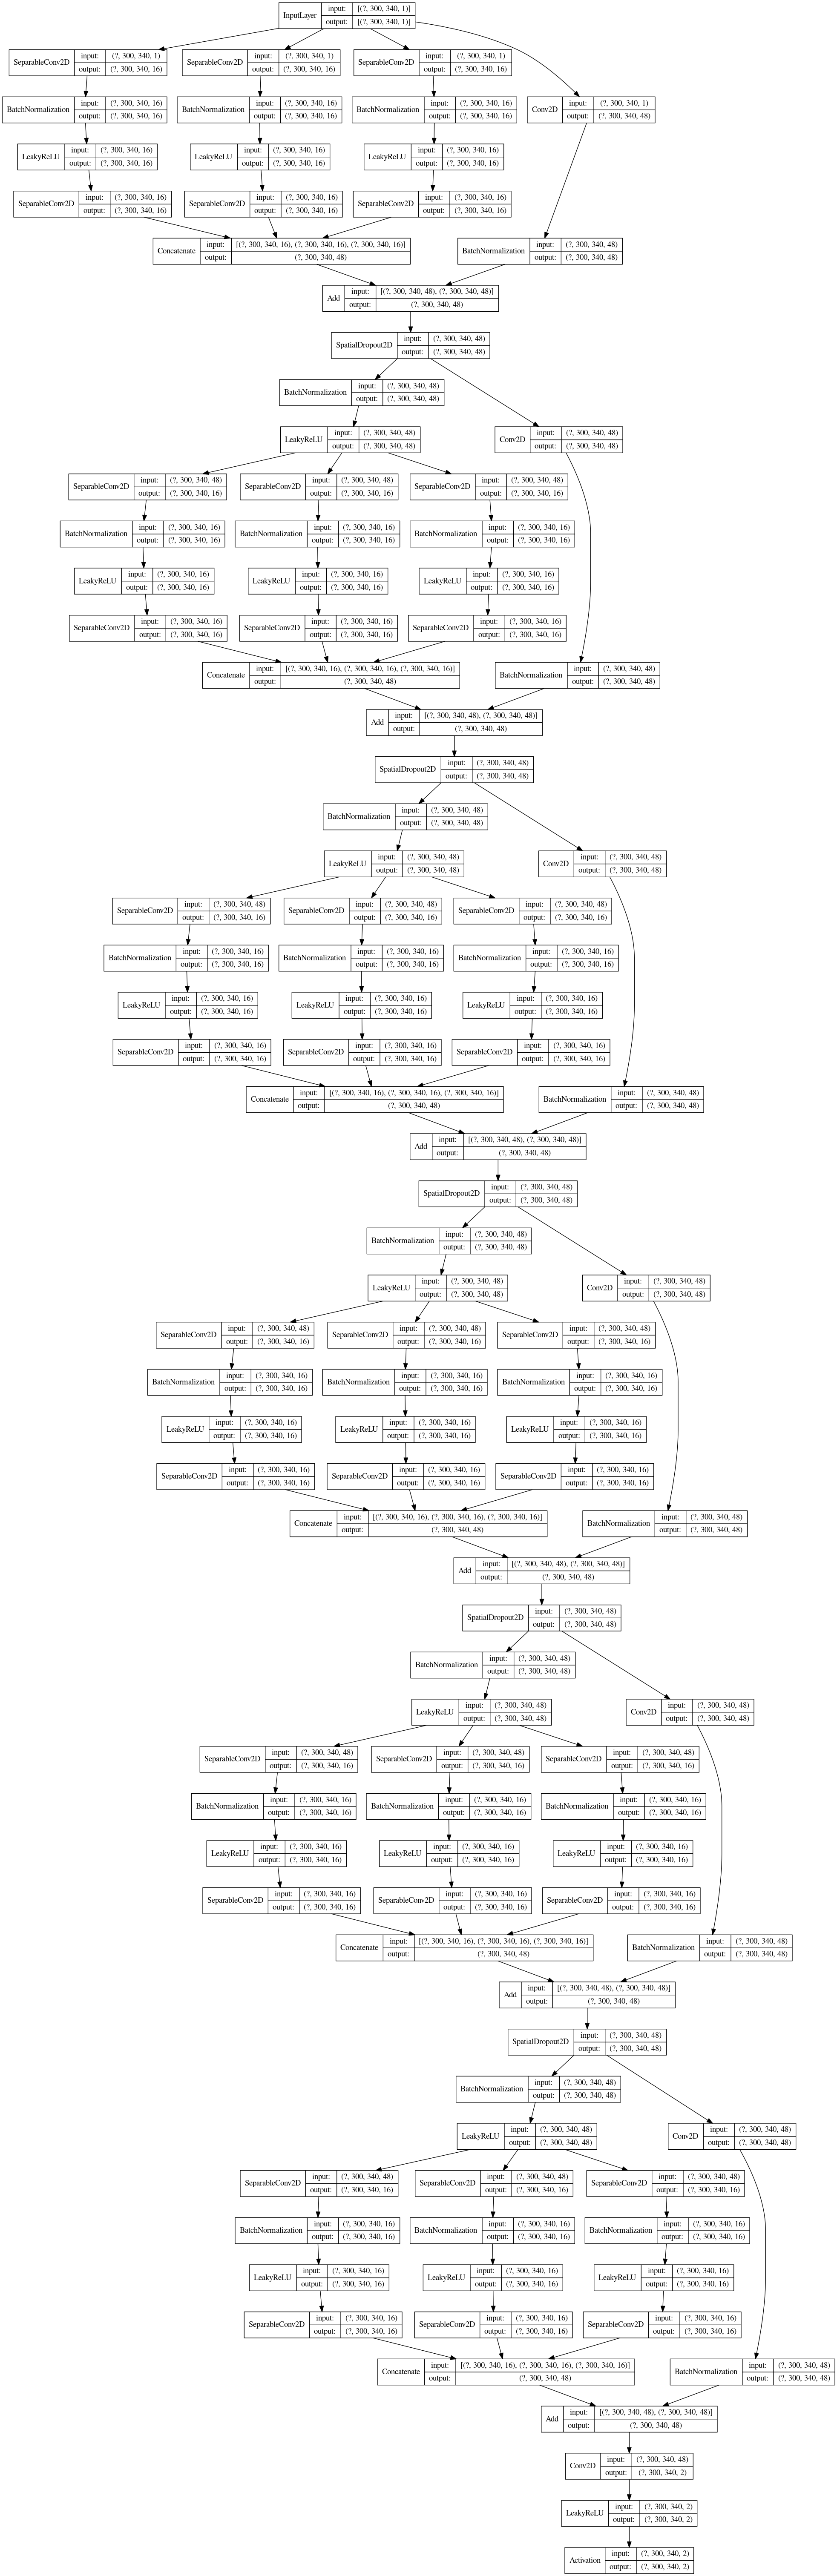

In [9]:
# In[8]

# ### MODEL GRAPH
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True,\
           show_layer_names=False,\
           to_file='saved_images/' + model_selection + '_' + model_number + '_architecture.png') 
    

In [10]:
# In[9]:

# ### CALLBACKS

# Choose which model to save
save_best=True

if save_best:
    savefilepath='models/best_' + model_selection + '_' + model_number + '_weights.h5'
else:
    savefilepath='models/last_' + model_selection + '_' + model_number + '_weights.h5'
                   
# Quiery the current directory
pwd = os.getcwd()
os.system('mkdir log_dir')
os.system('rm -rf log_dir/*')

log_dir = pwd + '/log_dir'
print(log_dir)

callbacks_list = [
# callback for logging the history
    tf.keras.callbacks.CSVLogger('models/' + model_selection + \
        '_' + model_number + '_history.csv', append=True),
            
# callback for tensorboard: launch from a different venv (not ipython) console as 
# 'tensorboard --logdir log_dir'
    tf.keras.callbacks.TensorBoard( 
        log_dir=log_dir,
        histogram_freq=0, 
        write_graph=True, 
        write_images=True,
        profile_batch=0),
    
# callback for early stopping     
    tf.keras.callbacks.EarlyStopping( 
        monitor='val_loss', 
        patience=200, 
        # verbose=1, 
        min_delta = 0.001,
        mode='min'),

# callback to save best or last model (here we save only the weights because the 
# dice coef loss is not stored in the model)    
    tf.keras.callbacks.ModelCheckpoint( 
        filepath=savefilepath,  
        monitor='val_loss', 
        save_best_only=save_best,      
        mode = 'min', 
        # verbose = 1,
        save_weights_only = True)]
   

/wsu/home/aa/aa14/aa1426/Documents/JENA/MYOTUBES_SEGMENTATION/Res-CR-Net_CXR_segmentation/log_dir


In [11]:
CLASSES

['lungs', 'non_lungs']

In [12]:
# In[10]:

# ### TRAINING   

epoch_num = 100
train_steps = 516 # Number of batches called in each epoch
val_steps = 17
  
if len(CLASSES) == 1:  
    history = model.fit(train_generator_1(), 
                        validation_data=val_generator_1(), 
                        steps_per_epoch=train_steps, 
                        validation_steps=val_steps, 
                        epochs=epoch_num,
                        initial_epoch=initial_epoch,
                        callbacks = callbacks_list)
elif len(CLASSES) > 1:
    history = model.fit(train_generator_2(), 
                        validation_data=val_generator_2(), 
                        steps_per_epoch=train_steps, 
                        validation_steps=val_steps, 
                        epochs=epoch_num,
                        initial_epoch=initial_epoch,
                        callbacks = callbacks_list)
        

Found 6191 images belonging to 1 classes.
Found 6191 images belonging to 1 classes.
Found 6191 images belonging to 1 classes.
  ...
    to  
  ['...']
Found 204 images belonging to 1 classes.
Found 204 images belonging to 1 classes.
Found 204 images belonging to 1 classes.
  ...
    to  
  ['...']
Train for 516 steps, validate for 17 steps
Epoch 1/100
INFO:tensorflow:batch_all_reduce: 180 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
INFO:tensorflow:batch_all_reduce: 180 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
516/516 [==============================] - 1562s 3s/step - loss: 0.2714 - tani_coeff: 0.7830 - val_loss: 0.2148 - val_tani_coeff: 0.8673
Epoch 2/100
516/516 [==============================] - 1456s 3s/step - loss: 0.2174 - tani_coeff: 0.8459 - val_loss: 0.2191 - val_tani_coeff: 0.8517
Epoch 3/100
516/516 [==============================] -

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



516/516 [==============================] - 1734s 3s/step - loss: 0.1268 - tani_coeff: 0.9352 - val_loss: 0.1228 - val_tani_coeff: 0.9424
Epoch 89/100
516/516 [==============================] - 1456s 3s/step - loss: 0.1268 - tani_coeff: 0.9352 - val_loss: 0.1241 - val_tani_coeff: 0.9434
Epoch 90/100
516/516 [==============================] - 1451s 3s/step - loss: 0.1263 - tani_coeff: 0.9355 - val_loss: 0.1218 - val_tani_coeff: 0.9433
Epoch 91/100
516/516 [==============================] - 1447s 3s/step - loss: 0.1266 - tani_coeff: 0.9349 - val_loss: 0.1235 - val_tani_coeff: 0.9412
Epoch 92/100
516/516 [==============================] - 1453s 3s/step - loss: 0.1263 - tani_coeff: 0.9356 - val_loss: 0.1228 - val_tani_coeff: 0.9445
Epoch 93/100
516/516 [==============================] - 1448s 3s/step - loss: 0.1260 - tani_coeff: 0.9358 - val_loss: 0.1215 - val_tani_coeff: 0.9450
Epoch 94/100
516/516 [==============================] - 1452s 3s/step - loss: 0.1262 - tani_coeff: 0.9356 - val_l

In [13]:
# In[11]:

# ### SAVE WEIGHTS AS H5

model.save_weights('models/' + model_selection + '_' + model_number + '_weights' + '.h5')

# ### SAVE ARCHITECTURE + WEIGHTS AS H5

model.save('models/' + model_selection + '_' + model_number + '_all' + '.h5',
        overwrite=True,include_optimizer=False,save_format='h5',signatures=None,options=None)


In [14]:
# # ### SAVE ARCHITECTURE + WEIGHTS + LOSSES + OPTIMIZATION AS FOLDER (only working in TF2.2) 

# model.save('models/' + model_selection + '_' + model_number + '_ALL')

In [15]:
print(model_selection,model_number)

model_16F_5R1_0R2 2020-10-16_21_26


Validation minimum reached at epoch 86
Validation maximum reached at epoch 97


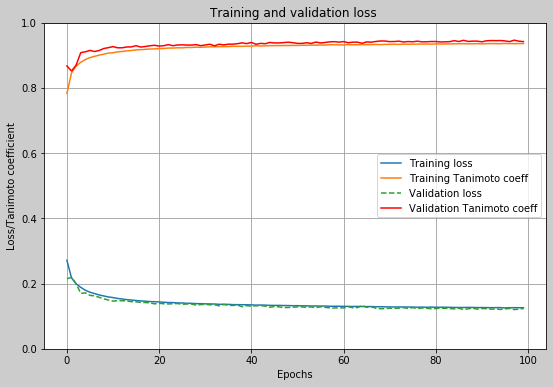

In [16]:
# In[12]:

# ### HISTORY

csv_df = pd.read_csv('models/' + model_selection + '_' + model_number + '_history.csv')
history_csv = csv_df[csv_df.columns[1:]].to_dict(orient='list')

skip = 1
loss_history_csv = history_csv['loss']
acc_history_csv = history_csv['tani_coeff']
val_loss_history_csv = history_csv['val_loss']
val_acc_history_csv = history_csv['val_tani_coeff']
epochs_csv = range(0, len(loss_history_csv) , skip)  

fig, ax = plt.subplots(ncols=1, nrows=1,facecolor=(.8, .8, .8), figsize=[9,6])
ax.set_facecolor('w')
ax.plot(epochs_csv, loss_history_csv[0::skip], '-', label='Training loss') 
ax.plot(epochs_csv, acc_history_csv[0::skip], '-', label='Training Tanimoto coeff') 
ax.plot(epochs_csv, val_loss_history_csv[0::skip], '--', label='Validation loss')
ax.plot(epochs_csv, val_acc_history_csv[0::skip], '-r', label='Validation Tanimoto coeff')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss/Tanimoto coefficient')
ax.set_ylim([0,1.0])
ax.grid(b=True, which='major', color=(.6, .6, .6), linestyle='-')
ax.set_title('Training and validation loss ')
ax.legend()

plt.savefig('models/' + model_selection + '_' + model_number + '_history_csv.png')

validation_minimum = np.argmin(val_loss_history_csv)
print(f"Validation minimum reached at epoch {validation_minimum}")
accuracy_maximum = np.argmax(val_acc_history_csv)
print(f"Validation maximum reached at epoch {accuracy_maximum}")


In [17]:
# In[13]:

# ### EVALUATION 

if len(CLASSES) == 1:
    test_scores=model.evaluate(val_generator_1(),steps=val_steps)
elif len(CLASSES) > 1:
    test_scores=model.evaluate(val_generator_2(),steps=val_steps)
    
print('Validation score = ',test_scores)


Found 204 images belonging to 1 classes.
Found 204 images belonging to 1 classes.
Found 204 images belonging to 1 classes.
  ...
    to  
  ['...']
17/17 [==============================] - 10s 612ms/step - loss: 0.1233 - tani_coeff: 0.9419
Validation score =  [0.12332400504280538, 0.9418751]


In [ ]:
# In[14]:

# ### LOADING/COMPILATION

# model_number = '2020-04-03_16_59'   
load_saved = True
load_best = False # if taking the model from the last epoch or True if taking the checkpoint model. 

if load_saved:
    # read in 
    json_file = open('models/' + model_selection + '_' + model_number + '.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)
    # load weights into new model
    if load_best:
        model.load_weights('models/best_' + model_selection + '_' + model_number + '_weights.h5')
    else:
        model.load_weights('models/last_' + model_selection + '_' + model_number + '_weights.h5')
    

In [18]:
# In[15]: 

# ### LOAD ENTIRE MODEL AND COMPILE
filepath = 'models/' + model_selection + '_' + model_number + '_all' + '.h5'
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    model = load_model(filepath, compile=False)     
    model.compile(optimizer=Adam(), loss=weighted_tani_loss, metrics=[tani_coeff]) 
    

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


In [19]:
# In[16]
    
# ### VALIDATION SET EVALUATION
# model.compile(optimizer=Adam(), loss=weighted_tani_loss, metrics=[tani_coeff])

if len(CLASSES) == 1:
    test_scores=model.evaluate(val_generator_1(),steps=val_steps)
elif len(CLASSES) > 1:
    test_scores=model.evaluate(val_generator_2(),steps=val_steps)
    
print('Validation score = ',test_scores)


Found 204 images belonging to 1 classes.
Found 204 images belonging to 1 classes.
Found 204 images belonging to 1 classes.
  ...
    to  
  ['...']
17/17 [==============================] - 5s 322ms/step - loss: 0.1233 - tani_coeff: 0.9418
Validation score =  [0.12334926338756785, 0.94179964]


In [20]:
# In[17]:

# ### VALIDATION SET PREDICTIONS

# if len(CLASSES) == 1:
#     y_pred = model.predict(val_generator_1(),steps=8)
# elif len(CLASSES) > 1:
#     y_pred = model.predict(val_generator_2(),steps=8)
    
# result = (y_pred > 0.5)*1        
# print(result.shape)

img_path = VAL_IMG_PATH + '/img/'
img_names = [f for f in listdir(img_path) if isfile(join(img_path, f))]
n_img = len(img_names)

lung_msk_path = VAL_MSK_PATH + '/lungs/'
non_lung_msk_path = VAL_MSK_PATH + '/non_lungs/'

x_val = np.zeros((n_img,HEIGHT,WIDTH,1))
y_true = np.zeros((n_img,HEIGHT,WIDTH,2))
y_pred = np.zeros((n_img,HEIGHT,WIDTH,2))

for i,name in enumerate(img_names):
    img = cv2.imread(img_path + name, cv2.IMREAD_GRAYSCALE).astype('float64')
    img *= 1/255
    x_val[i,:,:,0] = img
            
    lung_mask = cv2.imread(lung_msk_path + name, cv2.IMREAD_GRAYSCALE).astype('float64')
    lung_mask *= 1/255
    y_true[i,:,:,0] = lung_mask

    non_lung_mask = cv2.imread(non_lung_msk_path + name, cv2.IMREAD_GRAYSCALE).astype('float64')
    non_lung_mask *= 1/255
    y_true[i,:,:,1] = non_lung_mask

    img_input = np.expand_dims(img, axis = [0,-1])
    y_pred[i,:,:,:] = model(img_input).numpy()

result = (y_pred > 0.5)*1  
x_val = x_val[:,:,:,0]
x_val = np.expand_dims(x_val, axis = -1)

print(x_val.shape, y_true.shape, result.shape)

# ### OTHER METRICS
# if len(CLASSES) == 1:
#     x_val,y_val = next(val_generator_1())
# elif len(CLASSES) > 1:
#     x_val,y_val = next(val_generator_2())

# y_true = y_val
# y_pred = model.predict(x_val)

tani = tani_coeff(y_true,y_pred).numpy()
dice, jaccard, precision, recall, f1_score = other_metrics(y_true,y_pred,0.5)
print('dice = ', dice)
print('tani = ', tani)
print('jaccard = ', jaccard)
print('precision = ', precision)
print('recall = ', recall)
print('F1 score = ', f1_score)

(204, 300, 340, 1) (204, 300, 340, 2) (204, 300, 340, 2)
dice =  0.9574133702834249
tani =  0.9399926214475093
jaccard =  0.918305820345783
precision =  0.9574133522395853
recall =  0.9574133883272649
F1 score =  0.9574133702834248


In [ ]:
# In[18]

# ### PLOTS
pwd = os.getcwd()
os.system('mkdir saved_images')
img_path = os.path.join(pwd,'saved_images/')
print(img_path)

for ind in range(len(x_val)):

    class_threshold = get_class_threshold(NUM_CLASS)   
    
    # ### SELECT VALIDATION IMAGE

    print(ind)

    x = x_val[ind]
    y = y_true[ind]*class_threshold
    r = result[ind]*class_threshold     

    y = np.sum(y,axis=2)
    r = np.sum(r,axis=2)

    # Correction for r if using sigmoid instead of softmax activation 
    r[r>255] = 255      

    # print(x.shape,y.shape,r.shape)

    # Save the ground_truth and predicted mask figure       
    # cv2.imwrite(img_path + 'val_img_' + str(ind) + '_true_mask_' + model_number + '.png', y)
    # cv2.imwrite(img_path + 'val_img_' + str(ind) + '_predicted_mask_' + model_number + '.png', r)

    # Save image + mask figure
    fig = plt.figure(figsize=(20,10))
    fig.subplots_adjust(hspace=0.4, wspace=0.2)

    ax = fig.add_subplot(1, 3, 1)
    if x.shape[2] == 1:
        ax.imshow(np.squeeze(x), cmap="gray")
    elif x.shape[2] == 3: 
        ax.imshow(x)

    ax = fig.add_subplot(1, 3, 2)
    ax.imshow(y, cmap="gray")    
    ax = fig.add_subplot(1, 3, 3)
    ax.imshow(r, cmap="gray")

    plt.savefig(img_path + 'val_img_' + str(ind) + '_true_and_pred_mask_' + model_number + '.png')
      

In [ ]:
# In[19]
    
# ### TEST SET EVALUATION
# model.compile(optimizer=Adam(), loss=weighted_tani_loss, metrics=[tani_coeff])
# if len(CLASSES) == 1:
#     test_scores=model.evaluate(test_generator_1(),steps=1)
# elif len(CLASSES) > 1:
#     test_scores=model.evaluate(test_generator_2(),steps=1)
    
# print('Test score = ',test_scores)


In [ ]:
# print(input_img.shape,mask.shape,mask_float.shape,mask_binary.shape)